Analyzing chunk0.wav
Analyzing chunk1.wav
Analyzing chunk2.wav
Analyzing chunk3.wav
Analyzing chunk4.wav


error: required argument is not an integer

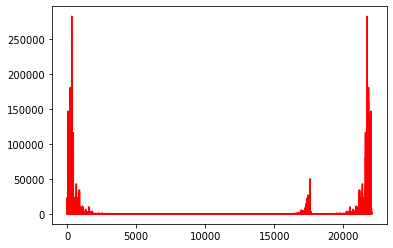

In [3]:
# New Aud to Mid


import matplotlib.pyplot as plt
import os
from scipy.fftpack import fft
from scipy.io import wavfile # get the api
from pydub import AudioSegment
from pydub.utils import make_chunks
from midiutil.MidiFile import MIDIFile
import math


chunkLength = 500
minThreshold = 25000
maxThreshold = 120000

time = 0    		# start at the beginning
mf = MIDIFile(1)    # only 1 track
track = 0   		# the only track
bpm = 83
mf.addTrackName(track, time, "Sample Track")
mf.addTempo(track, time, bpm)

myaudio = AudioSegment.from_file('musicTest5.wav' , "wav")
chunks = make_chunks(myaudio, chunkLength)

#iterate through chunks and analyze them
def main():
	if os.path.exists("output.mid"):
		os.remove("output.mid")
	else:
		print("The file does not exist")

	for i, chunk in enumerate(chunks):
		print("Analyzing chunk" + str(i) + ".wav")

		chunk_name = "chunk{0}.wav".format(i)

		chunk.export(chunk_name, format="wav")

		curFrequencies = runFFT(chunk_name)

		curMidi = getMidiFromFtt(curFrequencies)
		
		for note, amplitude in curMidi.items():
			writeMIDI(i, mapAtoV(amplitude), note)

		if os.path.exists(chunk_name):
			os.remove(chunk_name)

		else:
			print("The file does not exist")

#write a midi note to mf
def writeMIDI(startVal, amplitude, midiNote):

	channel = 0
	volume = amplitude

	pitch = midiNote 
	time = startVal*(chunkLength/500.)

	duration = 1*(chunkLength/500.)
	mf.addNote(track, channel, pitch, time, duration, volume)

#convert a frequency to a midi value
def freqToMid(frequency):
	if frequency > 0:
		midi = abs(math.log(frequency/440.0)/math.log(2) * 12 + 49)
		return midi
	else: 
		return 0

# get the important frequencies and amplitudes for a given chunk
def getMidiFromFtt(frequencies):
	midiDict = {}

	for frequency in range(len(frequencies)):

		curFreq = freqToMid(frequencies[frequency][0])

		if round(curFreq) in midiDict:
			if frequencies[frequency][1] > midiDict[round(curFreq)]:
				midiDict[round(curFreq)] = frequencies[frequency][1]
		else:
			midiDict[round(curFreq)] = frequencies[frequency][1]

	return midiDict

# map from amplitude space to velocity/volume space for the midi
def mapAtoV(amplitude):
	if amplitude > maxThreshold:
		return 127
	else:
		return int((((amplitude-minThreshold)/(maxThreshold-minThreshold)))*127)

# run the actual FFT on a chunk
def runFFT(chunk_name):

	frequencies = []

	fs, data = wavfile.read(chunk_name) # load the data
	a = data.T[0] 						# this is a two channel soundtrack, I get the first track
	b=[(ele/2**8.)*2-1 for ele in a]	# this is 8-bit track, b is now normalized on [-1,1)
	c = fft(b) 							# calculate fourier transform (complex numbers list)
	d = len(((c)//2)-1)  						# you only need half of the fft list (real signal symmetry)
	plotList = abs(c[:(d-1)])
	plt.plot(abs(c[:(d-1)]),'r') 

	for i in range(0, d-1):
		if plotList[i] > minThreshold:
			frequencies.append([i, plotList[i]])

	return frequencies

main()

with open("output.mid", 'wb') as outf:
	mf.writeFile(outf)

